In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import Matrix, zeros
from numpy.random import normal
from commpy.utilities  import signal_power, upsample
from commpy.modulation import Modem, QAMModem
from utils.dsp import firFilter, pulseShape, eyediagram, lowPassFIR, edc, fourthPowerFOE, dbp, cpr
from utils.models import mzm, linFiberCh, iqm, ssfm, edfa, phaseNoise, coherentReceiver

from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from tqdm.notebook import tqdm
from scipy import signal
import scipy.constants as const
import numba

In [2]:
# parâmetros da simulação
M      = 16            # Ordem da Modulação QAM
SpS    = 16            # Número de amostras por símbolo
Rs     = 90e9         # Taxa de símbolos 
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

Pi_dBm = 0  # potência de sinal óptico na entrada do modulador em dBm
π = np.pi

# parâmetros do IQM
Vπ = 2
Vb = -Vπ
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

In [3]:
### Transmissor

# gera sequência de bits pseudo-aleatórios
bitsTx   = np.random.randint(2, size=80000)    

# mapeia bits para símbolos QAM
mod = QAMModem(m=M)
symbTx = mod.modulate(bitsTx)
Es = mod.Es;

# normaliza energia média dos símbolos para 1
symbTx = symbTx/np.sqrt(Es)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso
#pulse = pulseShape('nrz', SpS)
pulse = pulseShape('rrc', SpS, N=1024, alpha=0.01, Ts=Ts)
pulse = pulse/np.max(np.abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

In [4]:
### Transmissor Óptico

# Modulador Mach-Zehnder
Ai      = np.sqrt(Pi)
sigTxo_ = iqm(Ai, 0.5*sigTx, Vπ, Vb, Vb)

Potência do sinal Tx (em dBm) = -11.37 dBm


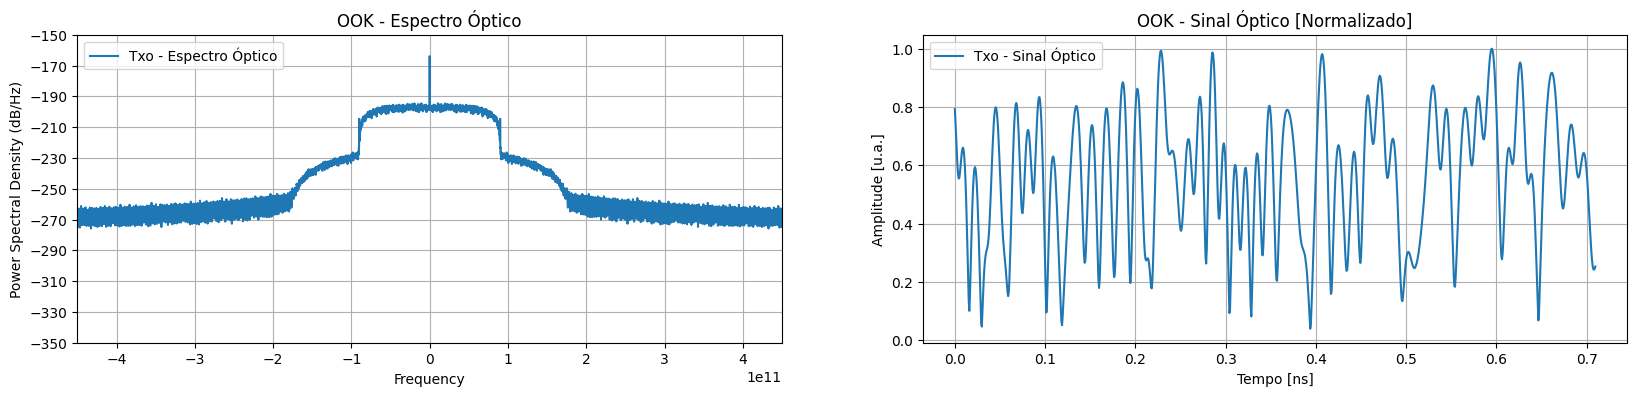

In [5]:
# Plota PSD

print('Potência do sinal Tx (em dBm) = %.2f dBm'%(10*np.log10(signal_power(sigTxo_)/1e-3)))

t = np.arange(0, symbTx.size)*(Ta/1e-9)
idX = np.arange(0,1023)

fig, axs = plt.subplots(1, 2, figsize=(20,4))

axs[0].set_title('OOK - Espectro Óptico')
axs[0].set_xlim(-5*Rs,5*Rs);
axs[0].set_ylim(-350,-150);
axs[0].psd(np.abs(sigTxo_)**2,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Txo - Espectro Óptico')
axs[0].legend(loc='upper left')

axs[1].set_title('OOK - Sinal Óptico [Normalizado]')
axs[1].plot(t[idX], np.abs(sigTxo_[idX])/max(np.abs(sigTxo_[idX])), label = 'Txo - Sinal Óptico' )
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].legend(loc='upper left')
axs[1].grid(True)